# Advanced Machine Learning Project - Image Super-Resolution

In [ ]:
# Imports
from google.colab import drive
import zipfile
import shutil
from skimage import io
import os

from matplotlib import pyplot as plt
import numpy as np
import cv2
import math

import random as python_random
import tensorflow as tf
from tensorflow import keras

np.random.seed(0)
python_random.seed(0)
tf.random.set_seed(0)
keras.utils.set_random_seed(0)
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Link Google Drive account, transfer dataset, and extract files
shutil.copy('/content/drive/My Drive/ImageSuperResolutionDataset.zip', 'ImageSuperResolutionDataset.zip')
zipf = zipfile.ZipFile('ImageSuperResolutionDataset.zip')
zipf.extractall()
zipf.close()

os.remove('ImageSuperResolutionDataset.zip') # Delete the copied zip file

### split_image function

This function takes as input an image and the target size of the returned images.

The goal is to split each image that is bigger than the target size into smaller images of the size target_size, by spreading the crops evenly across the original image.

This will be first used to augment the dataset, and then it will be used to generate even bigger images later (probably???).

In [ ]:
def split_image(image, target_size=(1000, 1000)):
    h, w, _ = image.shape
    target_h, target_w = target_size
    #print(w, h)

    # If the image is smaller than the target size, discard the image
    if h <= target_h or w <= target_w:
        #print(f"The image size ({h}, {w}) is smaller than the target size ({target_h}, {target_w}), discarding image.")
        return None

    cropped_images = [] # List to store the cropped images

    # Calculates the amount of images per axis
    tot_images_x = math.ceil(w/target_w)
    tot_images_y = math.ceil(h/target_h)

    # Calculates the amount of sliding per axis, so that each cropped image is as far as possible to the others and the amount of overlappings are equally distributed
    slide_w=int(w/tot_images_x)
    slide_h=int(h/tot_images_y)


    for j in range(tot_images_y):
        for i in range(tot_images_x):
            start_w = slide_w * i
            start_h = slide_h * j
            if(start_w + target_w > w):
                start_w = w-target_w
            if(start_h + target_h > h):
                start_h = h - target_h

            end_w = start_w + target_w
            end_h = start_h + target_h
            #print(start_w, end_w, start_h, end_h)

            cropped = image[start_h:end_h, start_w:end_w]
            #print("shape:", cropped.shape)
            cropped_images.append(cropped)

    # Converts the list of cropped images to a NumPy array
    return np.array(cropped_images)


### Example of split_image()

In the first example, the image is too small

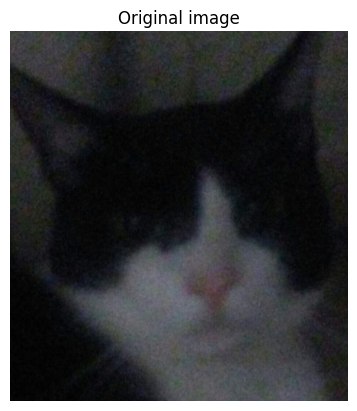

In [ ]:
example_image = io.imread('/content/drive/My Drive/cat2.jpg')

plt.imshow(example_image)
plt.title("Original image")
plt.axis('off')
plt.show()

In [ ]:
example_image.shape

(512, 468, 3)

In [ ]:
example_images = split_image(example_image)
if(example_images is not None):
    print("Shape of segments array:", example_images.shape)

In the second example, the image is split in 4

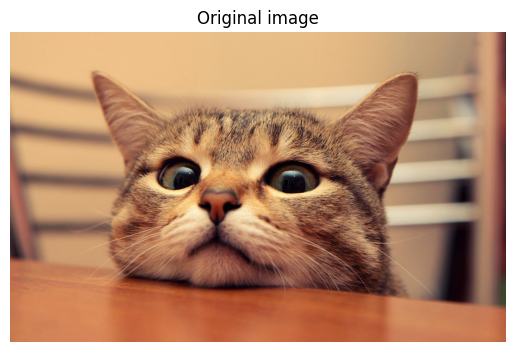

In [ ]:
example_image = io.imread('/content/drive/My Drive/cat.jpg')

plt.imshow(example_image)
plt.title("Original image")
plt.axis('off')
plt.show()

In [ ]:
example_image.shape

(1200, 1920, 3)

In [ ]:
example_images = split_image(example_image)
if(example_images is not None):
    print("Shape of segments array:", example_images.shape)

Shape of segments array: (4, 1000, 1000, 3)


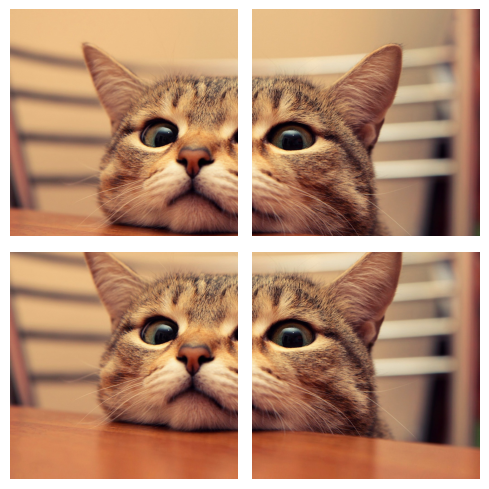

In [ ]:
# Plot the 4 split images
fig, axes = plt.subplots(2, 2, figsize=(5, 5))

# Plot each image in a subplot
axes[0, 0].imshow(example_images[0])
axes[0, 0].axis('off')  # Turn off axis ticks and labels
axes[0, 1].imshow(example_images[1])
axes[0, 1].axis('off')
axes[1, 0].imshow(example_images[2])
axes[1, 0].axis('off')
axes[1, 1].imshow(example_images[3])
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

In the third example, the image is split in 12. This shows the flexibility of the function.

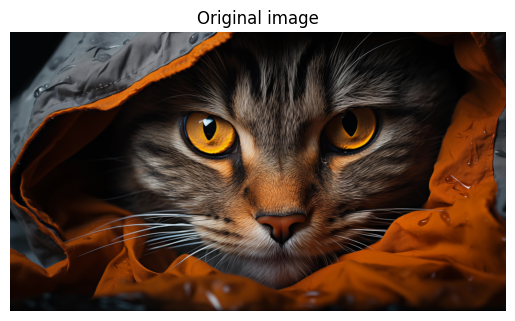

In [ ]:
example_image = io.imread('/content/drive/My Drive/high_res_cat.jpg')

plt.imshow(example_image)
plt.title("Original image")
plt.axis('off')
plt.show()

In [ ]:
example_image.shape

(2160, 3840, 3)

In [ ]:
example_images = split_image(example_image)
if(example_images is not None):
    print("Shape of segments array:", example_images.shape)

Shape of segments array: (12, 1000, 1000, 3)


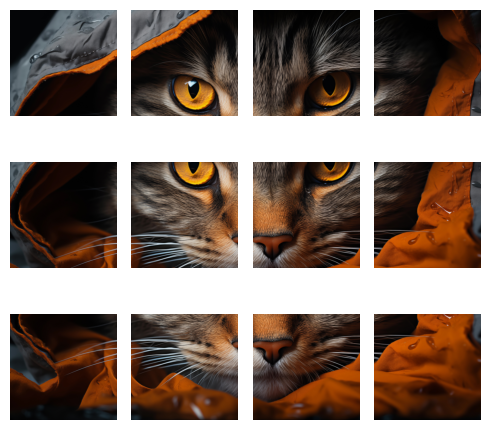

In [ ]:
# Plot the 12 split images
fig, axes = plt.subplots(3, 4, figsize=(5, 5))

axes = axes.flatten()

# Plot each image in a subplot
for i in range(len(example_images)):  # Loop through all 12 images
    axes[i].imshow(example_images[i])
    axes[i].axis('off')  # Turn off axis ticks and labels

plt.tight_layout()
plt.show()

### Dataset import and augmentation

In [ ]:
def import_images(folder_path, num_images, start_index=0, max_index=None):
    images_set = []  # Initialize the array as a list
    image_count = 0  # Counter for imported images
    if max_index is None:
        max_index = len(os.listdir(folder_path))

    for i in range(start_index, max_index):
        filename = os.listdir(folder_path)[i]
        if filename.endswith(('.jpg', '.jpeg', '.png')):
            if image_count < num_images:
                image_path = os.path.join(folder_path, filename)
                #print("Importing", filename)
                image = io.imread(image_path)
                images_set.append(image / 255.0)  # Append the image to the array
                image_count += 1  # Update the image count
            else:
                break

    return images_set, start_index + image_count  # Return the images and the next start index

In [ ]:
def augment_images(images, target_size=(1000, 1000)):
    augmented_images_list = []  # Initialize an empty list

    for image in images:
        split_images = split_image(image, target_size)  # Call split_image for augmentation
        if split_images is not None:
            augmented_images_list.extend(split_images)  # Append split images to the list

    return augmented_images_list

In [ ]:
# Imports the first 10 train images
train_index = 0
imported_images, train_index = import_images("ImageSuperResolutionDataset/training", 10, train_index)

train_set = augment_images(imported_images) # Aguments the imported images by using the split_image function

print("Number of images in the training set:", len(train_set))
print("Shapes of individual images:", train_set[0].shape)
#print(train_index)

Number of images in the training set: 60
Shapes of individual images: (1000, 1000, 3)


In [ ]:
# Calculates the train/test split
tot_images_in_dataset = len(os.listdir("ImageSuperResolutionDataset/training"))
train_index_max = int(tot_images_in_dataset * 0.75) # 75/25 train/test split
print(train_index_max) # The first 'train_index_max' images are used for training

375


In [ ]:
from tensorflow.keras import layers, models
import random
import gc

In [ ]:
def image_set_to_low_resolution(images, resize_shape=(250, 250)):
    resized_images = [
        cv2.resize(image, resize_shape, interpolation=cv2.INTER_AREA) for image in images
    ]
    return resized_images

In [ ]:
def fetch_batch_data(batch_size, input_generator=image_set_to_low_resolution):
    global train_index
    global train_index_max
    global train_set

    # Ensure train_set is always manageable in size
    while len(train_set) < batch_size:
        #print("Train index", train_index)
        if train_index == train_index_max:  # Reset train_index if at the end
            train_index = 0

        imported_images, train_index = import_images(
            "ImageSuperResolutionDataset/training",
            10,
            train_index,
            train_index_max
        )
        augmented_images = augment_images(imported_images)
        train_set.extend(augmented_images)

    # Randomly shuffle the train_set to select the batch
    random.shuffle(train_set)

    # Keep only the first `batch_size` images as the batch
    batch_set = train_set[:batch_size]
    #print("Batch set length", len(batch_set))

    # Update train_set to only contain the remaining images for future batches
    train_set = train_set[batch_size:]
    #print("Train set length after batch: ", len(train_set))

    downscaled_batch_set = input_generator(batch_set)
    #print("Downscaled_batch_set length: ", len(downscaled_batch_set))

    # Explicitly clear memory
    gc.collect()

    return downscaled_batch_set, batch_set

# Step 2: Create a generator to yield batches
def data_generator(batch_size, input_generator):
    while True:
        batch_images, batch_labels = fetch_batch_data(batch_size, input_generator)

        # Convert lists to NumPy arrays
        batch_images = np.array(batch_images)
        batch_labels = np.array(batch_labels)

        gc.collect()

        yield batch_images, batch_labels

#### Model 1

In [ ]:
# Define the model
model = models.Sequential()

# Input layer
model.add(layers.Input(shape=(250, 250, 3)))  # Updated input size to 250x250x3

# First transposed convolutional layer (upsample to 500x500)
model.add(layers.Conv2DTranspose(128, kernel_size=3, strides=2, padding='same', activation='relu'))

# Second transposed convolutional layer (upsample to 1000x1000)
model.add(layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding='same', activation='relu'))

# Final transposed convolutional layer to maintain the channel count
model.add(layers.Conv2DTranspose(3, kernel_size=3, strides=1, padding='same', activation='sigmoid'))  # Sigmoid for normalized outputs

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Summary of the model
model.summary()

# Example: Training with a data generator
batch_size = 16
steps_per_epoch = 25  # Number of batches per epoch

history = model.fit(
    data_generator(batch_size),  # Replace with your data generator
    steps_per_epoch=steps_per_epoch,
    epochs=10
)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_transpose_6 (Conv2DTranspose) │ (None, 500, 500, 128)       │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_7 (Conv2DTranspose) │ (None, 1000, 1000, 64)      │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_8 (Conv2DTranspose) │ (None, 1000, 1000, 3)       │           1,731 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 79,107 (309.01 KB)

 Trainable params: 79,107 (309.01 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - loss: 0.0832
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - loss: 0.0320
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - loss: 0.0128
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - loss: 0.0075
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - loss: 0.0067
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - loss: 0.0066
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - loss: 0.0058
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - loss: 0.0062
Epoch 9/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - loss: 0.0053
Epoch 10/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - loss: 0.0055


In [ ]:
def plot_loss(history):
    # Create a figure for the loss plot
    plt.figure(figsize=(6, 5))

    # Plot Training Loss
    plt.plot(history.history['loss'], label='Training Loss')
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Show the plot
    plt.show()

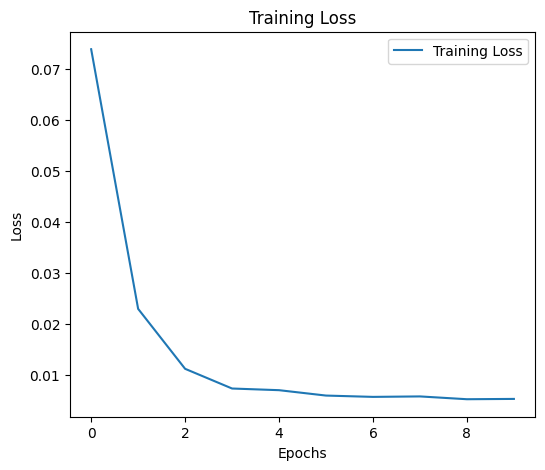

In [ ]:
gc.collect()
plot_loss(history)

#### model 2

In [ ]:
def image_set_to_upscaled_low_resolution(images, resize_shape=(250, 250), upscale_shape=(1000, 1000)):
    # Downscale images to the specified resize shape
    resized_images = [
        cv2.resize(image, resize_shape, interpolation=cv2.INTER_AREA) for image in images
    ]

    # Upscale the downscaled images back to the specified upscale shape
    upscaled_images = [
        cv2.resize(image, upscale_shape, interpolation=cv2.INTER_LINEAR) for image in resized_images
    ]

    return upscaled_images

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError

input_shape=(None, None, 3)

model = Sequential([
        # Feature extraction layer
        Conv2D(32, (9, 9), activation='relu', padding='same', input_shape=input_shape),
        # Non-linear mapping layer
        Conv2D(16, (1, 1), activation='relu', padding='same'),
        # Reconstruction layer
        Conv2D(3, (5, 5), activation='linear', padding='same')
    ])

model.compile(optimizer=Adam(learning_rate=0.0001), loss=MeanSquaredError(), metrics=['mean_squared_error'])

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, None, None, 32)      │           7,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, None, None, 16)      │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, None, None, 3)       │           1,203 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,539 (37.26 KB)

 Trainable params: 9,539 (37.26 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
batch_size = 16
steps_per_epoch = 25  # Number of batches per epoch

history = model.fit(
    data_generator(batch_size, image_set_to_upscaled_low_resolution),
    steps_per_epoch=steps_per_epoch,
    epochs=10
)

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - loss: 0.2240 - mean_squared_error: 0.2240
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - loss: 0.1136 - mean_squared_error: 0.1136
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - loss: 0.0276 - mean_squared_error: 0.0276
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - loss: 0.0131 - mean_squared_error: 0.0131
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - loss: 0.0102 - mean_squared_error: 0.0102
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - loss: 0.0100 - mean_squared_error: 0.0100
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - loss: 0.0082 - mean_squared_error: 0.0082
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - loss: 0.0076 - mean_squared_error: 0.0076
Epoch 9/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - loss: 0.0074 - mean_squared_error: 0.0074
Epoch 10/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - loss: 0.0071 - mean_squared_error: 0.0071


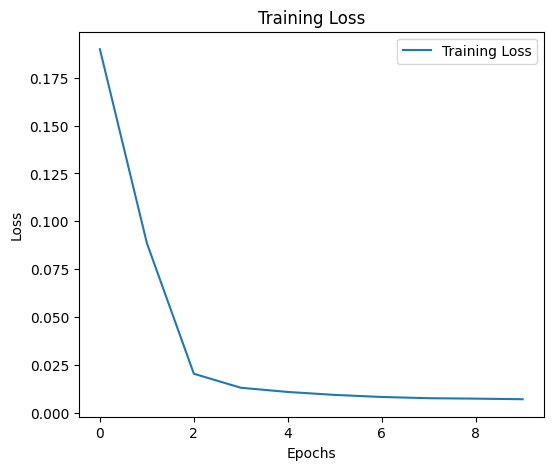

In [ ]:
gc.collect()
plot_loss(history)

In [ ]:
test_start = train_index_max + 1

In [ ]:
imported_test_images, test_start = import_images(
            "ImageSuperResolutionDataset/training",
            1,
            test_start
        )
test_set = augment_images(imported_test_images)
downscaled_test_set = np.array(image_set_to_upscaled_low_resolution(test_set))

In [ ]:
reconstructed_images = model.predict(downscaled_test_set)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


In [ ]:
reconstructed_images.shape

(6, 1000, 1000, 3)

In [ ]:
reconstructed_images = np.clip(reconstructed_images, 0, 1)  # Ensure values are in [0, 1]
reconstructed_images = (reconstructed_images * 255).astype(np.uint8)  # Convert to 8-bit format

In [ ]:
def display_image_comparison(downscaled_images, reconstructed_images, original_images, index):
    """
    Display a side-by-side comparison of downscaled, reconstructed, and original images.

    Parameters:
    downscaled_images (numpy.ndarray): Array of downscaled images (N, h, w, 3).
    reconstructed_images (numpy.ndarray): Array of reconstructed images (N, H, W, 3).
    original_images (numpy.ndarray): Array of original high-resolution images (N, H, W, 3).
    index (int): The index of the image to display.

    Returns:
    None
    """
    # Ensure index is valid
    if index < 0 or index >= len(original_images):
        raise ValueError("Invalid index. Must be in range [0, len(original_images) - 1].")

    # Extract the specific images
    downscaled = downscaled_images[index]
    reconstructed = reconstructed_images[index]
    original = original_images[index]

    # Resize downscaled for visualization (match original and reconstructed size)
    downscaled_resized = cv2.resize(downscaled, (original.shape[1], original.shape[0]))

    # Plot the images side by side
    plt.figure(figsize=(15, 5))

    # Downscaled image
    plt.subplot(1, 3, 1)
    plt.imshow(downscaled_resized)
    plt.title("Downscaled (Upsampled for Display)")
    plt.axis("off")

    # Reconstructed image
    plt.subplot(1, 3, 2)
    plt.imshow(reconstructed)
    plt.title("Reconstructed")
    plt.axis("off")

    # Original image
    plt.subplot(1, 3, 3)
    plt.imshow(original)
    plt.title("Original")
    plt.axis("off")

    # Show the plot
    plt.tight_layout()
    plt.show()

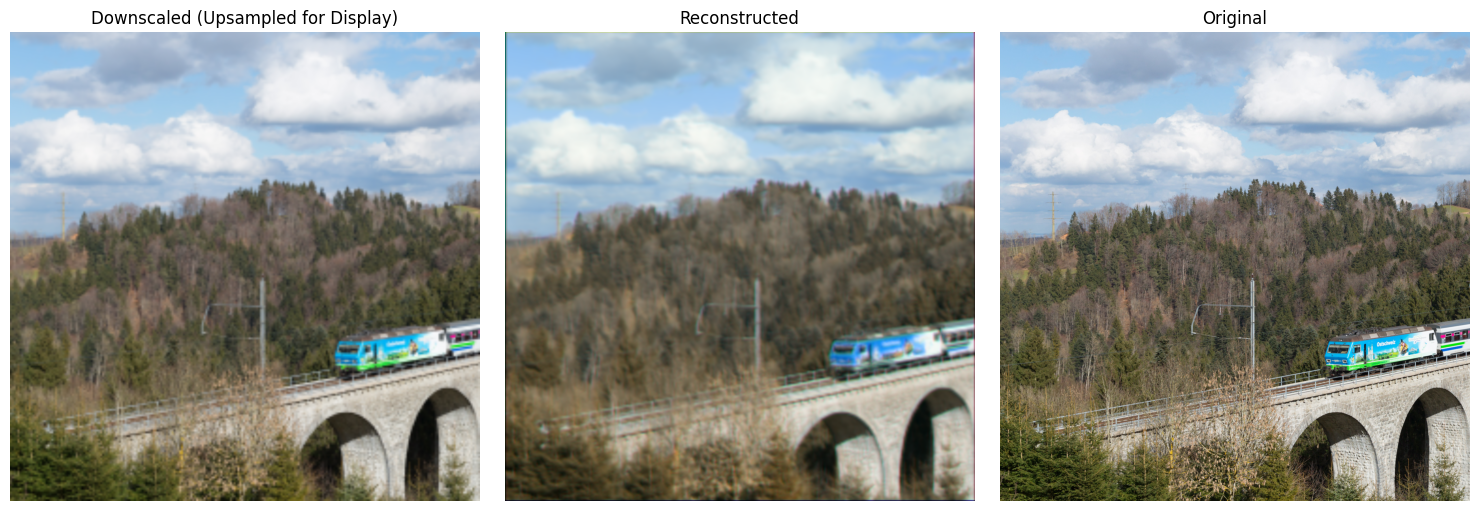

In [ ]:
display_image_comparison(downscaled_test_set, reconstructed_images, test_set, index=0)

In [ ]:
import numpy as np

# Rescale to [0, 1]
def rescale_to_unit_range(images):
    min_val = np.min(images)
    max_val = np.max(images)

    # Avoid division by zero in case of uniform values
    if max_val > min_val:
        images = (images - min_val) / (max_val - min_val)
    else:
        images = np.zeros_like(images)  # All values are the same, set to zero

    return images


In [ ]:
reconstructed_images = rescale_to_unit_range(reconstructed_images)

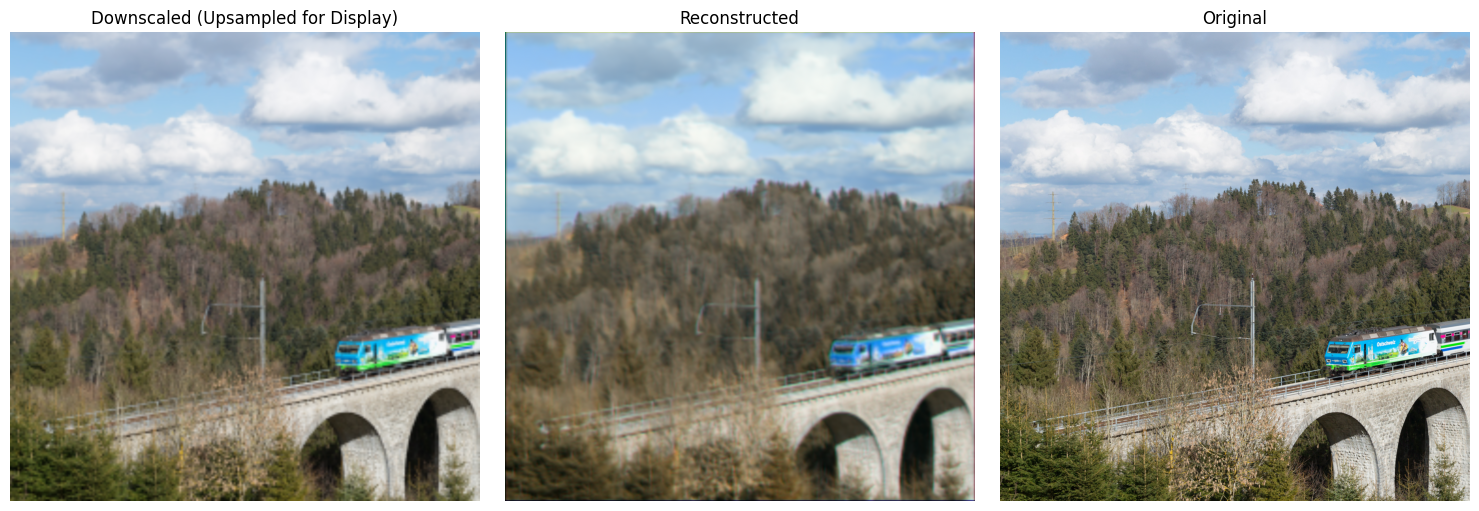

In [ ]:
display_image_comparison(downscaled_test_set, reconstructed_images, test_set, index=0)